In [1]:
# ! python -m numpy.f2py -c Montecarlo.f90 -m montecarlo
! python -m numpy.f2py -c Kirchoff_sub_rnt.f90 -m kirchhoff2

running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "kirchhoff2" sources
f2py options: []
f2py:> /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof/src.macosx-10.7-x86_64-3.7/kirchhoff2module.c
creating /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof/src.macosx-10.7-x86_64-3.7
Reading fortran codes...
	Reading file 'Kirchoff_sub_rnt.f90' (format:free)
	Reading file '/opt/intel/compilers_and_libraries_2020.1.216/mac/mkl/include/mkl_dss.fi' (format:fix)
Post-processing...
	Block: kirchhoff2
			Block: kirchhoff
				Block: dss_factor
				Block: dss_factor_real
				Block: dss_factor_complex
				Block: dss_solve
				Block: dss_solve_real
				Block: dss_solve_complex
Post-processing (stage 2)...
Building modules...
	Building module "kirchhoff2"...
		Constructi

/usr/local/bin/gfortran -Wall -g -m64 -Wall -g -undefined dynamic_lookup -bundle /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof/var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof/src.macosx-10.7-x86_64-3.7/kirchhoff2module.o /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof/var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof/src.macosx-10.7-x86_64-3.7/fortranobject.o /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof/Kirchoff_sub_rnt.o -L/usr/local/gfortran/lib/gcc/x86_64-apple-darwin16/6.3.0 -L/usr/local/gfortran/lib/gcc/x86_64-apple-darwin16/6.3.0/../../.. -L/usr/local/gfortran/lib/gcc/x86_64-apple-darwin16/6.3.0/../../.. -lgfortran -o ./kirchhoff2.cpython-37m-darwin.so
Removing build directory /var/folders/q1/8h226kws6qj8hctylvlyybhh0000gn/T/tmp8xg1vzof


In [2]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import math
import time
import montecarlo as mcmc
import kirchhoff2
from scipy import signal
from scipy import stats

In [3]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

In [4]:
mx = 40
my = 40
val = [1.0,0.0]
Rload = 1.0
volt = 0.001*(mx-1.)
gamma = 0.1
mtot = mx*my
sites = 0.1
patch = 6
axis = 0

In [5]:
def gen_lat2(A,sites,patch):
    k=0
    while k < (int(mtot*sites + patch*np.shape(A)[0])):
        ii = np.random.randint(0,mx)
        jj = np.random.randint(0,my)
        if A[ii,jj] != 0.01:
            A[ii,jj] = 0.01
            k = k+1
    return A

def gen_lat(A,patch,axis):
    ## A : array, patch : part of A which has the opposite phase, axis = 0,1 (X,Y)
    nx,ny = np.shape(A)
    if axis == 0:
        for k in range(4*ny*patch):
            ii = np.random.randint(nx//2,(nx//2)+patch)
            jj = np.random.randint(0,ny)
            if A[ii,jj] != 0.0:
                A[ii,jj] = 0.0 
    else :
        for k in range(4*nx*patch):
            jj = np.random.randint(ny//2,(ny//2)+patch)
            ii = np.random.randint(0,nx)
            if A[ii,jj] != 0.0:
                A[ii,jj] = 0.0
    return A

def gen_fil(A,patch,axis):
    nx,ny = np.shape(A)
    A[nx//2:nx//2+patch,:] = 0.01 
    return A    

In [6]:
pot = np.zeros(mtot+1)

phi1 = np.ones((mx,my))
phi2 = np.ones((mx,my))

phi1 = gen_fil(phi1,patch,axis)
phi1 = gen_lat2(phi1,sites,0)

phi2 = gen_lat2(phi2,sites,patch)

# phi2 = np.absolute(phi2 - 1.)

indices = np.where(phi1 == 0.01)
values_greater_than_3 = phi1[indices]
count = len(values_greater_than_3)
print(count)
indices = np.where(phi2 == 0.01)
values_greater_than_3 = phi2[indices]
count = len(values_greater_than_3)
print(count)

400
400


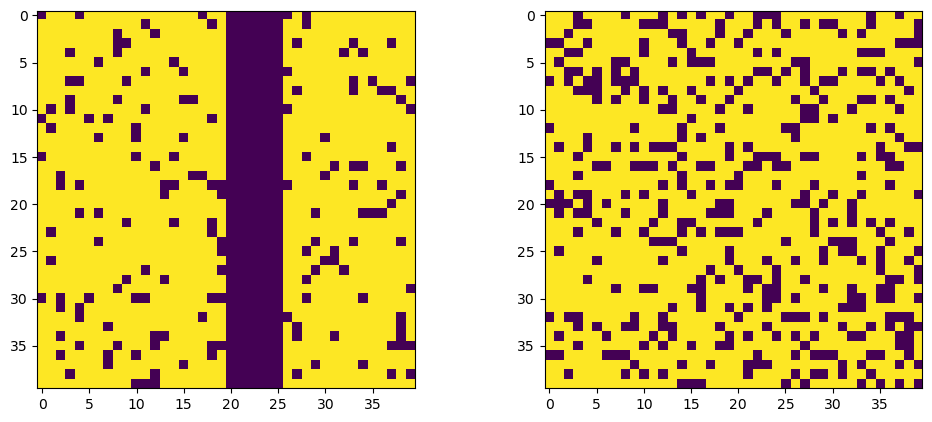

In [7]:
f = plt.figure(figsize=(12, 5)); # plot the calculated values  

sp =  f.add_subplot(1, 2, 1 );
plt.imshow(np.transpose(phi1))

sp =  f.add_subplot(1, 2, 2 );
plt.imshow(np.transpose(phi2))

plt.show()

In [8]:
r1 = []
r2 = []
prob = [0.8,0.2]
phi1 = np.ones((mx,my))
phi2 = np.ones((mx,my))
# sites = 0.1
# patch = 2
# axis = 1
dum=38285

if axis == 1:
    Axis = 'X'
else : 
    Axis = 'Y'

for k in range(10000):
    phi1 = np.ones((mx,my))
    phi1 = gen_fil(phi1,patch,axis)
    phi1 = gen_lat2(phi1,sites,0)
    pot1,iext,resist1,gmat = kirchhoff2.kirchhoff(gamma, phi1, Rload, volt, mtot, mx, my)
    r1.append((volt - pot1[mtot])/(pot1[mtot]/Rload))
    
    phi2 = np.ones((mx,my))
#     phi2 = gen_lat(phi2,patch,axis)
    phi2 = gen_lat2(phi2,sites,patch)
#     phi2 = np.absolute(phi2 - 1.)
    pot2,iext,resist2,gmat = kirchhoff2.kirchhoff(gamma, phi2, Rload, volt, mtot, mx, my)
    r2.append((volt - pot2[mtot])/(pot2[mtot]/Rload))

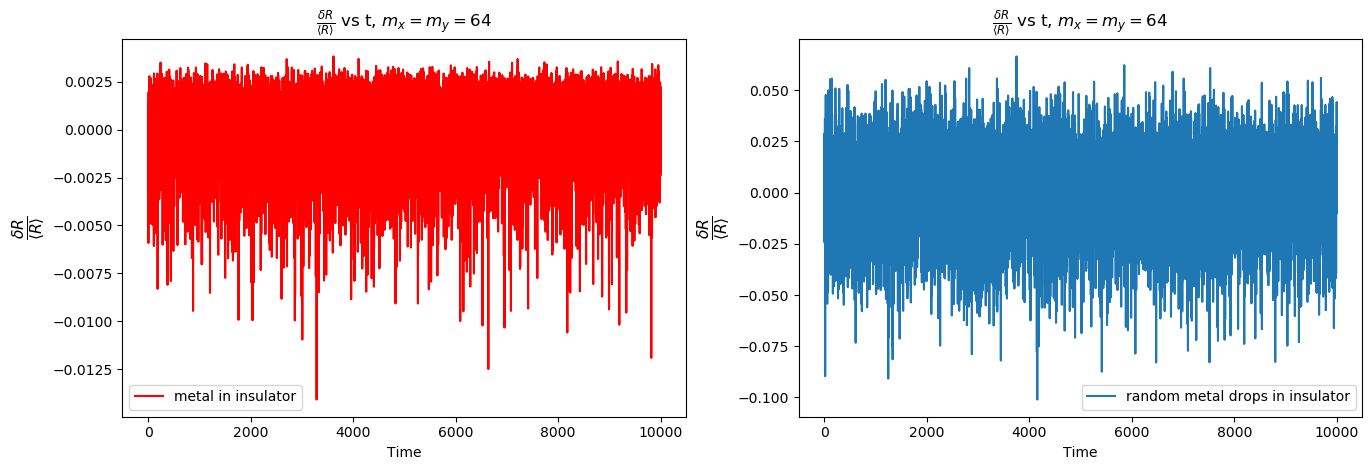

In [9]:
# print(r1)

f = plt.figure(figsize=(16, 5)); # plot the calculated values  

sp =  f.add_subplot(1, 2, 1 );
r1 = np.array(r1)
dr1 = r1 - np.mean(r1)
plt.plot(dr1/np.mean(r1), label = "metal in insulator", color = 'red')
plt.xlabel("Time")
plt.ylabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
# plt.ylim(-0.1,0.1)
# plt.xlim(0,500)
plt.legend()
plt.title(r'$\frac{\delta R}{\langle R \rangle}$ vs t, $m_x = m_y = 64$ ')    
    

sp =  f.add_subplot(1, 2, 2 );
r2 = np.array(r2)
dr2 = r2 - np.mean(r2)
# plt.plot(dr2/np.mean(r2), label = "insulator in metal")
plt.plot(dr2/np.mean(r2), label = "random metal drops in insulator")
plt.xlabel("Time")
plt.ylabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
# plt.ylim(-0.1,0.1)
# plt.xlim(0,500)
plt.legend()
plt.title(r'$\frac{\delta R}{\langle R \rangle}$ vs t, $m_x = m_y = 64$ ')
# # plt.savefig(path+"Rvt.pdf")

plt.show()

In [10]:
# f = plt.figure(figsize=(12, 5)); # plot the calculated values  

# sp =  f.add_subplot(1, 2, 1 );
# plt.imshow(np.transpose(resist1))

# sp =  f.add_subplot(1, 2, 2 );
# # _, bins1, _ = plt.hist(r1,bins=100, color = 'red', label = 'metal in insulator')
# _, bins1, _ = plt.hist(dr1/np.mean(r1),bins=100, density=False, color = 'red', label = 'metal in insulator')
# mu1, sigma1 = stats.norm.fit(dr1/np.mean(r1))
# best_fit_line = stats.norm.pdf(bins1, mu1, sigma1)
# # plt.plot(bins1, best_fit_line, color = 'black')
# # plt.xlabel("Time")
# # plt.xlabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
# plt.xlabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
# # plt.xlim(-0.2,0.2)
# plt.legend()
# # plt.title(r'$\frac{\delta R}{\langle R \rangle}$ vs t, $m_x = m_y = 64$ ')    


# plt.title('filament thickness : ' + format(patch)+ ' ,' + ' axis = ' + Axis)
# # plt.savefig("rnt_test/dist_fil_"+format(patch) +"_met_in_ins_"+Axis+"_check.pdf")



# plt.show()

In [11]:
# f = plt.figure(figsize=(12, 5)); # plot the calculated values  

# sp =  f.add_subplot(1, 2, 1 );
# plt.imshow(np.transpose(resist2))

# sp =  f.add_subplot(1, 2, 2 );
# # _, bins2, _ = plt.hist(r2,bins=100, color = 'blue', label = 'insulator in metal')
# # _, bins2, _ = plt.hist(dr2/np.mean(r2),bins=100, density=False, color = 'blue', label = 'insulator in metal')
# _, bins2, _ = plt.hist(dr2/np.mean(r2),bins=100, density=False, color = 'blue', label = 'random metallic drops')
# mu2, sigma2 = stats.norm.fit(dr2/np.mean(r2))
# best_fit_line = stats.norm.pdf(bins2, mu2, sigma2)
# # plt.plot(bins2, best_fit_line, color = 'black')
# plt.xlabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
# # plt.xlabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
# # plt.xlim(-0.08,0.08)
# plt.legend()
# # plt.title('filament thickness : ' + format(patch)+ ' ,' + ' axis = ' + Axis)
# plt.title(format(sites*100)+'% metal droplet coverage')
# # plt.title(r'$\frac{\delta R}{\langle R \rangle}$ vs t, $m_x = m_y = 64$ ')    
    

    
    
    
# # plt.savefig("rnt_test/dist_fil"+format(patch) +"_ins_in_met_"+Axis+"_.pdf")
# plt.show()

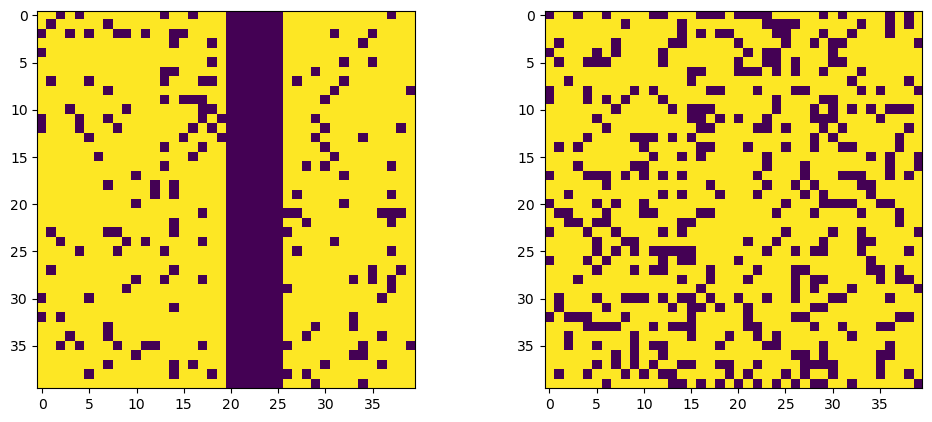

In [12]:

f = plt.figure(figsize=(12, 5)); # plot the calculated values  

sp =  f.add_subplot(1, 2, 1 );
plt.imshow(np.transpose(resist1))

sp =  f.add_subplot(1, 2, 2 );
plt.imshow(np.transpose(resist2))



plt.show()

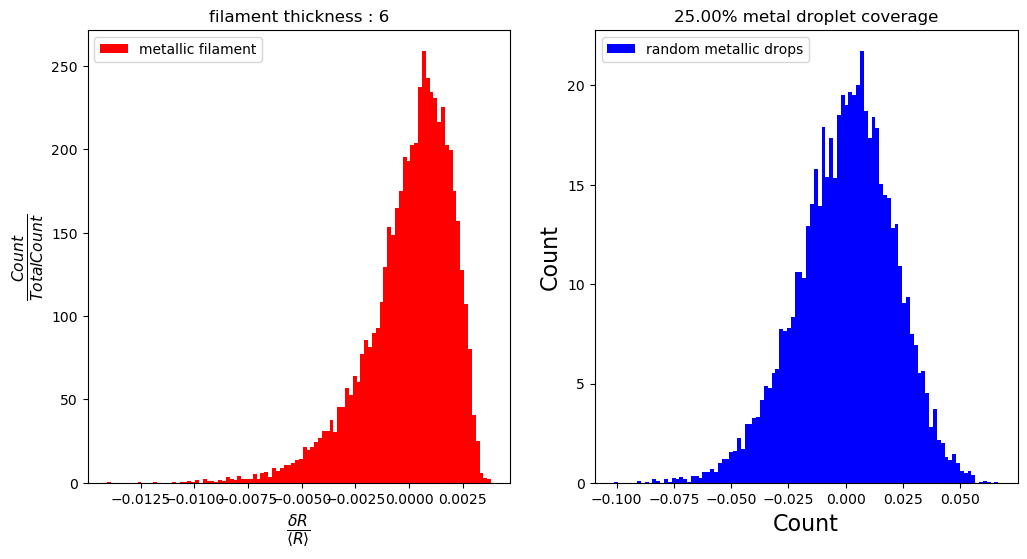

In [13]:
# plt.hist(r1,bins=100, color = 'red')

# print(r1)

f = plt.figure(figsize=(12, 6)); # plot the calculated values  

sp =  f.add_subplot(1, 2, 1 );
# _, bins1, _ = plt.hist(r1,bins=100, color = 'red', label = 'metal in insulator')
_, bins1, _ = plt.hist(dr1/np.mean(r1),bins=100, density=True, color = 'red', label = 'metallic filament')
mu1, sigma1 = stats.norm.fit(dr1/np.mean(r1))
best_fit_line = stats.norm.pdf(bins1, mu1, sigma1)
# plt.plot(bins1, best_fit_line, color = 'black')
plt.xlabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
plt.ylabel(r'$\frac{Count}{Total Count}$', fontsize = 16)
# plt.xlim(-0.2,0.2)
plt.legend()
# plt.title(r'$\frac{\delta R}{\langle R \rangle}$ vs t, $m_x = m_y = 64$ ')    


plt.title('filament thickness : ' + format(patch))
# plt.savefig("rnt_test/dist_fil_"+format(patch) +"_met_in_ins_"+Axis+"_check.pdf")



sp =  f.add_subplot(1, 2, 2 );
# _, bins2, _ = plt.hist(r2,bins=100, color = 'blue', label = 'insulator in metal')
# _, bins2, _ = plt.hist(dr2/np.mean(r2),bins=100, density=False, color = 'blue', label = 'insulator in metal')
_, bins2, _ = plt.hist(dr2/np.mean(r2),bins=100, density=True, color = 'blue', label = 'random metallic drops')
mu2, sigma2 = stats.norm.fit(dr2/np.mean(r2))
best_fit_line = stats.norm.pdf(bins2, mu2, sigma2)
# plt.plot(bins2, best_fit_line, color = 'black')
plt.xlabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
plt.ylabel(r'$\frac{Count}{Total Count}$', fontsize = 16)
# plt.xlim(-0.08,0.08)
plt.legend()
# plt.title('filament thickness : ' + format(patch)+ ' ,' + ' axis = ' + Axis)
plt.title(format((sites + (patch*mx)/mtot)*100,'.2f' )+'% metal droplet coverage')
# plt.title(r'$\frac{\delta R}{\langle R \rangle}$ vs t, $m_x = m_y = 64$ ')    
    

    
    
    
# plt.savefig("rnt_test2/hist_"+format(patch) +"_M_"+format((sites + (patch*mx)/mtot)*100,'.2f' )+"_.pdf")
plt.show()

# print(np.diff(bins1))

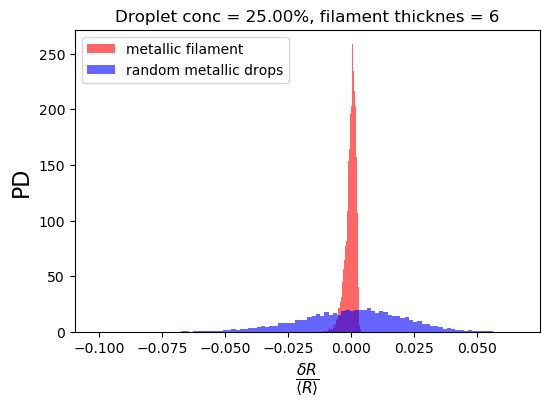

In [14]:
plt.hist(dr1/np.mean(r1),bins=100, density=True, color = 'red', label = 'metallic filament', alpha = 0.6)
plt.hist(dr2/np.mean(r2),bins=100, density=True, color = 'blue', label = 'random metallic drops', alpha = 0.6)
plt.xlabel(r'$\frac{\delta R}{\langle R \rangle}$', fontsize = 16)
plt.ylabel(r'PD', fontsize = 16)
plt.title(r'Droplet conc = '+format((sites + (patch*mx)/mtot)*100,'.2f' )+'%, filament thicknes = '+format(patch))
plt.legend()
# plt.savefig("rnt_test2/hist2_"+format(patch) +"_M_"+format((sites + (patch*mx)/mtot)*100,'.2f' )+"_.pdf")
plt.show()

In [15]:
print("Mean :",mu1, mu2)
print("Sigma :",sigma1, sigma2)

Mean : -1.4578928342334762e-16 -3.470557174978239e-17
Sigma : 0.0020296344341379376 0.021057930007507636


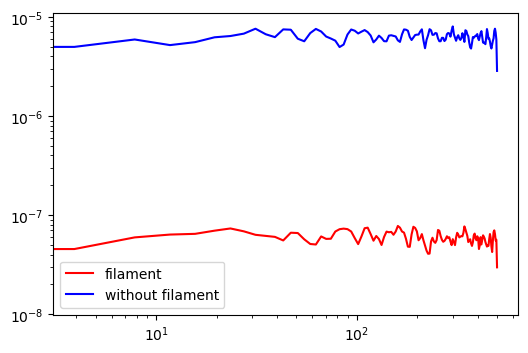

In [16]:
fs = 1000.

beta = 10.0
window_length = 256
numoverlap = window_length/2.
kaiserw = signal.get_window(('kaiser', beta), window_length) # Kaiser window
f1, R_ps1 = np.absolute(signal.welch(dr1/np.mean(r1), fs, nperseg = window_length, 
                                     window=kaiserw, noverlap = numoverlap, scaling = 'spectrum'))
f2, R_ps2 = np.absolute(signal.welch(dr2/np.mean(r2), fs, nperseg = window_length, 
                                     window=kaiserw, noverlap = numoverlap, scaling = 'spectrum'))

plt.loglog(f1, R_ps1,label = "filament", color = 'red')
plt.loglog(f2, R_ps2,label = "without filament", color = 'blue')
plt.legend()
plt.show()

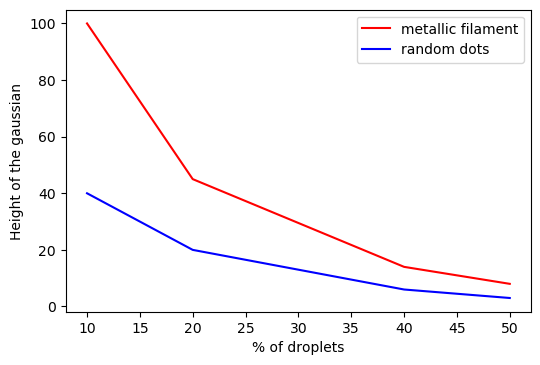

In [19]:
Hf = np.array([100,45,14,8])
Hm = np.array([40,20,6,3])
cover = np.array([10.,20.,40.,50.])


plt.plot(cover,Hf, label = "metallic filament", color = 'red')
plt.plot(cover, Hm, label = "random dots", color = 'blue')
# plt.plot(coverage,sigma_mi/sigma_im, label = "ratio" )
plt.legend()
plt.xlabel("% of droplets")
plt.ylabel("Height of the gaussian")
plt.show()

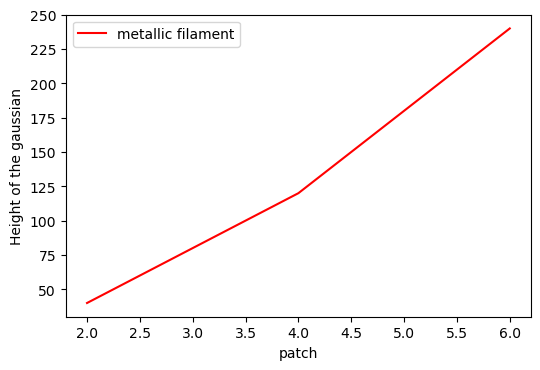

In [21]:
Hf = np.array([40,120,240])
Hm = np.array([40,20,6,3])
cover = np.array([2,4,6])


plt.plot(cover,Hf, label = "metallic filament", color = 'red')
# plt.plot(cover, Hm, label = "random dots", color = 'blue')
# plt.plot(coverage,sigma_mi/sigma_im, label = "ratio" )
plt.legend()
plt.xlabel("patch")
plt.ylabel("Height of the gaussian")
plt.show()